In [1]:
from plot import *

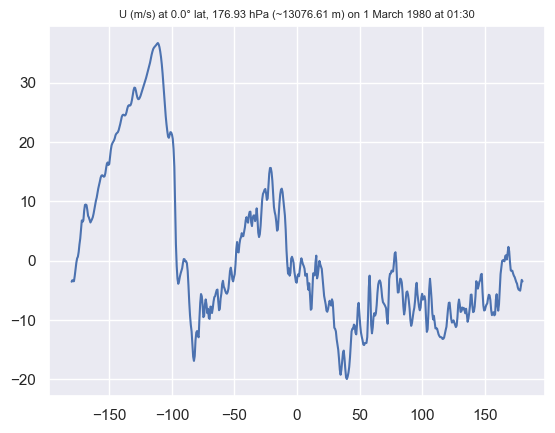

In [3]:
plot_variable_at_time_level_and_latitude_vs_longitude("MERRA2_100.tavg3_3d_asm_Nv.19800301.nc4", "U",
                                                      time=0, level=71-30, latitude=180)

In [3]:
%matplotlib notebook
slider = plot_interactive_contour_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                          time=0, title="East Wind (m/s)")


<IPython.core.display.Javascript object>

In [4]:
%matplotlib notebook
slider = plot_interactive_contour_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                                          time=0, title="North Wind (m/s)")


<IPython.core.display.Javascript object>